<a href="https://colab.research.google.com/github/amimulhasan/Deep-Learning/blob/main/hybrid_CNN%2BLSTM_LUng_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the lung disease dataset
!kaggle datasets download fatemehmehrparvar/lung-disease
# !unzip -q lung-disease.zip


Dataset URL: https://www.kaggle.com/datasets/fatemehmehrparvar/lung-disease
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/34.9M [00:00<?, ?B/s]
100% 34.9M/34.9M [00:00<00:00, 993MB/s]


In [ ]:
import zipfile

zip_path = '/content/lung-disease.zip'
extract_to = 'lung-disease'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Unzipping completed!")

Unzipping completed!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os



In [ ]:
base_dir = '/content/lung-disease/Lung X-Ray Image/Lung X-Ray Image'

# Data split - since dataset is already grouped by folders
# we can split using validation_split parameter
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(64,64),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(64,64),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 2780 images belonging to 3 classes.
Found 695 images belonging to 3 classes.


In [ ]:
model = models.Sequential()

# CNN feature extractor
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

# Output shape now is (6,6,128)
# So reshape properly
model.add(layers.Reshape((36, 128)))  # (6*6=36, 128 features)

# LSTM
model.add(layers.LSTM(64))

# Dense layers
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(train_generator.num_classes, activation='softmax'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 36, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 147,011 (574.26 KB)

 Trainable params: 147,011 (574.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.3896 - loss: 1.0879

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


87/87 ━━━━━━━━━━━━━━━━━━━━ 34s 343ms/step - accuracy: 0.3899 - loss: 1.0877 - val_accuracy: 0.5050 - val_loss: 1.0052
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 27s 305ms/step - accuracy: 0.5154 - loss: 0.9623 - val_accuracy: 0.6806 - val_loss: 0.7757
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 295ms/step - accuracy: 0.6742 - loss: 0.7652 - val_accuracy: 0.7410 - val_loss: 0.6217
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 294ms/step - accuracy: 0.7274 - loss: 0.6644 - val_accuracy: 0.7525 - val_loss: 0.5626
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 294ms/step - accuracy: 0.7472 - loss: 0.6080 - val_accuracy: 0.8101 - val_loss: 0.4895
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 293ms/step - accuracy: 0.7724 - loss: 0.5602 - val_accuracy: 0.7871 - val_loss: 0.5261
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 296ms/step - accuracy: 0.7879 - loss: 0.5215 - val_accuracy: 0.7669 - val_loss: 0.5173
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 294ms/step - accuracy: 0.7992 - loss: 0.5133 - val_accuracy: 0.792

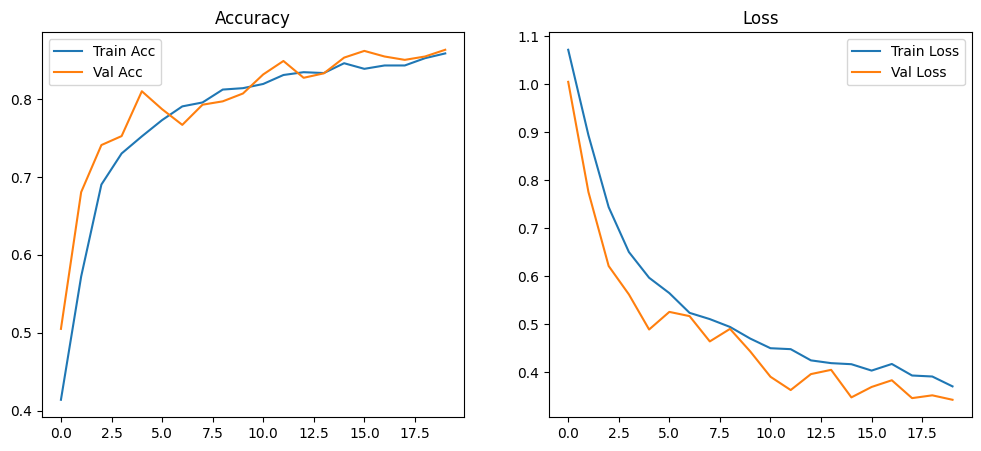

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


In [ ]:
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc*100:.2f}%")


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.8279 - loss: 0.3611
Validation Accuracy: 86.33%


In [ ]:
from tensorflow.keras.preprocessing import image

img_path = '/content/lung-disease/Lung X-Ray Image/Lung X-Ray Image/Normal/1.jpg'  # change as needed
img = image.load_img(img_path, target_size=(64,64))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
class_index = np.argmax(pred)
class_label = list(train_generator.class_indices.keys())[class_index]
print(f"Predicted Class: {class_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
Predicted Class: Normal
